# 回帰分析を判別に応用
通常、回帰分析は連続した値である量的データを予測するのに用いるが、ルールベースで予測値を変換することで質的データにすることができる。例えば2値分析の場合は予測値が0.5以上の場合に陽性として0.5未満の場合に陰性とすることがあり、3値以上の場合は最大値のインデックスを予測値にすることができる。

また、回帰分析は予測値が量的データでありデータの取り得る範囲も限定されていないためカテゴリになっている目的変数をワンホットエンコーディングして0と1の2値にして誤差を計測することで誤差が大きい場合には目的変数を選択した項目で説明できていないことが言える。

# ライブラリのインポート

In [1]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# データの読み込み

In [2]:
df = pd.read_csv("iris.csv")
df.head()

,category,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2


# カテゴリデータをワンホットエンコーディング

In [3]:
df_dum = pd.get_dummies(df, columns=["category"])
df_dum.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),category_0,category_1,category_2
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


# 分類寄与率の算出

In [4]:
x_table = df.drop("category", axis=1)
x_name = x_table.columns
x = x_table.values
y0 = df_dum["category_0"].values
y1 = df_dum["category_1"].values
y2 = df_dum["category_2"].values
y = df["category"].values

In [5]:
model = DTC()
model.fit(x, y)
imp = model.feature_importances_
dfi = pd.DataFrame(imp)
dfi.index = x_name
dfi.columns = ["category"]
dfi = dfi.sort_values("category", ascending=False)
dfi

,category
petal length (cm),0.564056
petal width (cm),0.422611
sepal length (cm),0.013333
sepal width (cm),0.000000


# 分類寄与率の高い項目で変数選択してモデル構築および評価

In [6]:
x_table = pd.concat([df["petal width (cm)"], df["petal length (cm)"]],axis=1)
x_name = x_table.columns
x_high = x_table.values

In [7]:
model_high_0 = LR()
model_high_1 = LR()
model_high_2 = LR()
model_high_0.fit(x_high, y0)
model_high_1.fit(x_high, y1)
model_high_2.fit(x_high, y2)
y_pred_high_0 = model_high_0.predict(x_high)
y_pred_high_1 = model_high_1.predict(x_high)
y_pred_high_2 = model_high_2.predict(x_high)

In [8]:
high_pred=[]
for i in range(len(x_high)):
    tmp=[]
    tmp.append([y_pred_high_0[i], y_pred_high_1[i], y_pred_high_2[i]])
    tmp = np.array(tmp)
    high_pred.append(np.argmax(tmp))
print("accuracy = %.2f"%(accuracy_score(y, high_pred)))

accuracy = 0.77


# 分類寄与率の低い項目で変数選択してモデル構築および評価

In [9]:
x_table = pd.concat([df["sepal width (cm)"], df["sepal length (cm)"]],axis=1)
x_name = x_table.columns
x_low = x_table.values

In [10]:
model_low_0 = LR()
model_low_1 = LR()
model_low_2 = LR()
model_low_0.fit(x_low, y0)
model_low_1.fit(x_low, y1)
model_low_2.fit(x_low, y2)
y_pred_low_0 = model_low_0.predict(x_low)
y_pred_low_1 = model_low_1.predict(x_low)
y_pred_low_2 = model_low_2.predict(x_low)

In [11]:
low_pred=[]
for i in range(len(x_low)):
    tmp=[]
    tmp.append([y_pred_low_0[i], y_pred_low_1[i], y_pred_low_2[i]])
    tmp = np.array(tmp)
    low_pred.append(np.argmax(tmp))
print("accuracy = %.2f"%(accuracy_score(y, low_pred)))

accuracy = 0.79


正解率で比較したときに分類寄与率が低い方が精度が高いことが分かった。その原因を考察するため、今度は分類寄与率の高低度合いと各カテゴリごとのモデルで予測値とワンホットエンコーディングで2値変換した理論値で誤差を計算する。

# カテゴリごとに誤差を算出する

In [12]:
low0 = y_pred_low_0 - y0
low1 = y_pred_low_1 - y1
low2 = y_pred_low_2 - y2
high0 = y_pred_high_0 - y0
high1 = y_pred_high_1 - y1
high2 = y_pred_high_2 - y2

# 分類寄与率の低い項目を説明変数にした場合で誤差を可視化

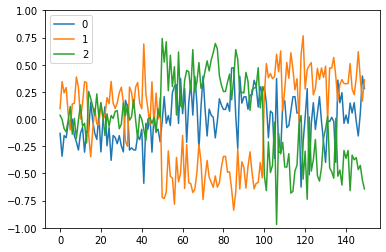

In [13]:
plt.plot(range(len(low0)), low0, label="0")
plt.plot(range(len(low1)), low1, label="1")
plt.plot(range(len(low2)), low2, label="2")
plt.legend()
plt.ylim(-1, 1)
plt.show()

# 分類寄与率の高い項目を説明変数にした場合で誤差を可視化

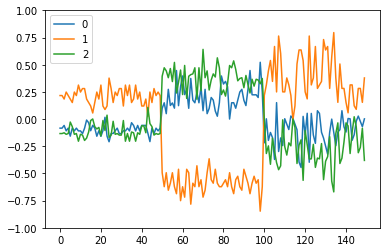

In [14]:
plt.plot(range(len(high0)), high0, label="0")
plt.plot(range(len(high1)), high1, label="1")
plt.plot(range(len(high2)), high2, label="2")
plt.legend()
plt.ylim(-1, 1)
plt.show()

可視化したデータからは分類寄与率が高いデータで作成されたモデルの方が誤差が安定しており尚且つ小さいことが分かる。

# 要約統計量を用いて数値でデータを比較
各データに対して二乗平方値を用いて誤差について考察する。ここで注目するところとしてはバラつきである標準偏差(std)と全体の値となる平均値(mean)・中央値(50%)・最大値(max)・最小値(min)を確認する。

In [15]:
dfe = pd.DataFrame([np.sqrt(low0**2), np.sqrt(high0**2), np.sqrt(low1**2), np.sqrt(high1**2), np.sqrt(low2**2), np.sqrt(high2**2)])
dfe = dfe.T
dfe.columns = ["low0", "high0", "low1", "high1", "low2", "high2"]
dfal0 = dfe["low0"].describe()
dfal1 = dfe["low1"].describe()
dfal2 = dfe["low2"].describe()
dfah0 = dfe["high0"].describe()
dfah1 = dfe["high1"].describe()
dfah2 = dfe["high2"].describe()
dfa = pd.concat([dfal0, dfah0, dfal1, dfah1, dfal2, dfah2],axis=1)
dfa.columns = dfe.columns
dfa

,low0,high0,low1,high1,low2,high2
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.176223,0.146928,0.366455,0.391629,0.288118,0.254578
std,0.129446,0.107329,0.200070,0.206593,0.219617,0.158041
min,0.000278,0.000213,0.000772,0.006749,0.000841,0.000250
25%,0.062249,0.078367,0.223631,0.216447,0.088767,0.133065
50%,0.151112,0.120832,0.362282,0.314412,0.258204,0.235705
75%,0.277393,0.197997,0.520342,0.589821,0.448811,0.380442
max,0.625996,0.522485,0.838278,0.847110,0.969417,0.669747


各項目に着目してみるとラベルが1の時に誤差の平均値が他のラベルと異なり分類寄与率の高い項目の方が高くなる。ここから、ラベルが1の場合に使用されている項目で目的変数を説明しきれていないことが考察できる。

## 回帰分析を使用した分類の図示
質的データの目的変数に対して説明変数の変数の数が二つの場合は2次元のグラフで表すことができるため図示する事ができる。ここで、実際に2次元のデータを回帰分析で分類した結果を表示してみる。
### 分類カテゴリが2つの場合
分類カテゴリが2つの場合は回帰分析の予測結果が0.5以上の場合に1として0.5未満の場合を0と予測する。回帰分析は特徴の一つとして残差の合計値が0になる事を踏まえておく。

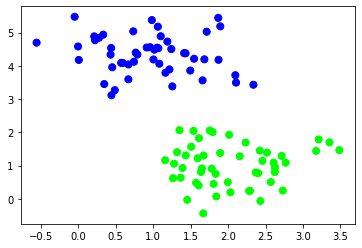

In [16]:
from sklearn.datasets import make_blobs
x, y = make_blobs(n_samples=100, centers=2,random_state=0, cluster_std=0.60)
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap="brg")
plt.show()

In [17]:
model = LR()
model.fit(x, y)
y_pred = np.where(model.predict(x)>=0.5, 1, 0)
print(accuracy_score(y, y_pred))

1.0


In [18]:
X, Y = np.meshgrid(np.linspace(min(x[:,0]), max(x[:,0]), 1000), np.linspace(min(x[:,1]), max(x[:,1]), 1000))
XY = np.column_stack([X.ravel(), Y.ravel()])
decision_area = model.predict(XY)

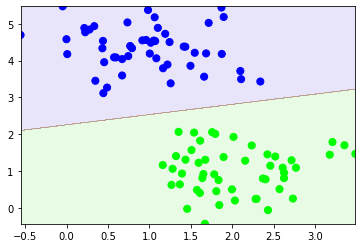

In [19]:
decision_area = np.where(decision_area>=0.5, 1, 0).reshape(X.shape)
plt.contourf(X, Y, decision_area, alpha=0.1, cmap="brg")
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap="brg")
plt.xlim(min(x[:, 0]),max(x[:, 0]))
plt.ylim(min(x[:, 1]),max(x[:, 1]))
plt.show()

### 分類カテゴリが3つ以上の場合
カテゴリが3つ以上の場合は回帰分析の予測結果が一番大きいカテゴリが分類結果になる。

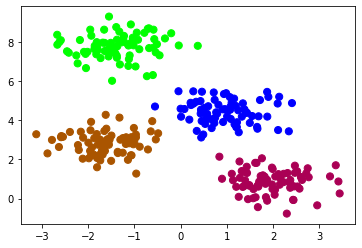

In [20]:
x, y = make_blobs(n_samples=300, centers=4,random_state=0, cluster_std=0.60)
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap="brg")
plt.show()

In [21]:
dfy = pd.DataFrame(y)
dfy.columns = ["ans"]
dfy.head()

,ans
0,1
1,3
2,0
3,3
4,1


#### ダミー変数を使って目的変数にワンホットエンコーディングを行う

In [22]:
dfy = pd.get_dummies(dfy, columns=["ans"])
dfy.head()

,ans_0,ans_1,ans_2,ans_3
0,0,1,0,0
1,0,0,0,1
2,1,0,0,0
3,0,0,0,1
4,0,1,0,0


ダミー変数を目的変数としてダミー変数ごとに学習する。実際に実装する際にはfor文を用いてカラムでループしておくと簡単にできる。

In [23]:
model0 = LR()
model1 = LR()
model2 = LR()
model3 = LR()
model0.fit(x, dfy["ans_0"])
model1.fit(x, dfy["ans_1"])
model2.fit(x, dfy["ans_2"])
model3.fit(x, dfy["ans_3"])

LinearRegression()

In [24]:
X, Y = np.meshgrid(np.linspace(min(x[:,0]), max(x[:,0]), 1000), np.linspace(min(x[:,1]), max(x[:,1]), 1000))
XY = np.column_stack([X.ravel(), Y.ravel()])
decision_area0 = model0.predict(XY).reshape(-1, 1)
decision_area1 = model1.predict(XY).reshape(-1, 1)
decision_area2 = model2.predict(XY).reshape(-1, 1)
decision_area3 = model3.predict(XY).reshape(-1, 1)

In [25]:
decision_area_list = np.hstack((decision_area0, decision_area1))
decision_area_list = np.hstack((decision_area_list, decision_area2))
decision_area_list = np.hstack((decision_area_list, decision_area3))
decision_area = []
for i in range(len(decision_area_list)):
    decision_area.append(np.argmax(decision_area_list[i]))
decision_area = np.array(decision_area).reshape(X.shape)

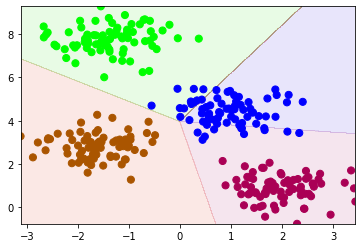

In [26]:
plt.contourf(X, Y, decision_area, alpha=0.1, cmap="brg")
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap="brg")
plt.xlim(min(x[:, 0]),max(x[:, 0]))
plt.ylim(min(x[:, 1]),max(x[:, 1]))
plt.show()